In [2]:
from mesa import Model, Agent
from mesa.time import RandomActivation

import random

In [3]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
        
class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)

### What happened with <code>super().__init__(unique_id, model)</code>?

Since <code>MoneyAgent</code> is the child of the parent class <code>Agent</code>, it calls the <code>__init__()</code> method of the parent and store the unique_id and model.

In [4]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    def step(self):
        if self.wealth == 0:
            return
        other_agent = random.choice(self.model.schedule.agents)
        other_agent.wealth += 1
        self.wealth -= 1

class MoneyModel(Model):
    def __init__(self, N):
        self.num_agents = N
        self.schedule = RandomActivation(self)
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            
    def step(self):
        self.schedule.step()

### How <code>Step</code> Method works?
For now, let’s use one of the simplest ones: <code>RandomActivation</code> which *activates all the agents once per step, in random order.*

Every agent is expected to have a <code>step</code> method, which *takes a model object as its only argument.*
→ this is the agent’s action when it is activated.

We add an agent to the <code>schedule</code> using the <code>add</code> method;

when **we call the <code>schedule</code>’s <code>step</code> method, it shuffles the order of the agents, then activates them all, one at a time.**

In [4]:
model = MoneyModel(10)

In [12]:
model.num_agents

10

In [28]:
model.schedule.agents

In [29]:
model.schedule.agents[0]

In [30]:
model.schedule.agents[0].unique_id

0

In [31]:
model.schedule.agents[1].unique_id

1

In [32]:
# all agent have same wealth
for i, agent in enumerate(model.schedule.agents):
    print(agent.unique_id, agent.wealth)

0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1


In [35]:
model.step()

In [36]:
# some agents exchanged their wealths
for i, agent in enumerate(model.schedule.agents):
    print(agent.unique_id, agent.wealth)

9 1
1 0
4 2
2 0
3 0
5 1
6 1
0 1
8 2
7 2


In [37]:
model.step()

In [38]:
# again, some agents exchanged their wealths
for i, agent in enumerate(model.schedule.agents):
    print(agent.unique_id, agent.wealth)

6 1
8 2
7 2
2 0
0 1
5 1
3 1
1 0
9 0
4 2


In [39]:
for i in range(100):
    model.step()

In [40]:
for i, agent in enumerate(model.schedule.agents):
    print(agent.unique_id, agent.wealth)

0 1
3 1
6 0
9 1
7 0
2 0
4 0
1 4
5 2
8 1


(array([4., 0., 4., 0., 0., 1., 0., 0., 0., 1.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

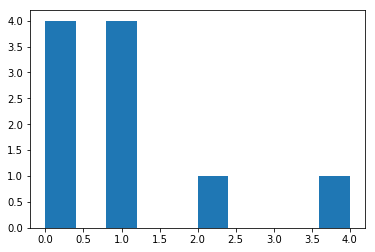

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
agent_wealths = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths)

In [45]:
model = MoneyModel(1000)
for i in range(100):
    model.step()

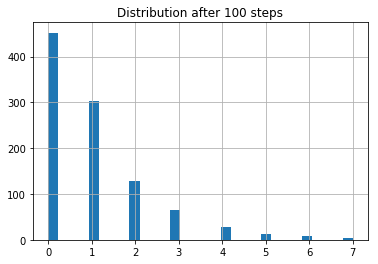

In [68]:
import matplotlib.pyplot as plt
%matplotlib inline
agent_wealths = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths, bins = 30)
plt.title("Distribution after 100 steps")
plt.grid()

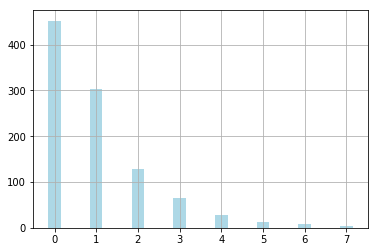

In [79]:
d = {}
for i in range(max(agent_wealths)+1):
    d[i] = agent_wealths.count(i)
for k, v in d.items():
    plt.bar(k, v, width = 0.3, color = "lightblue")
plt.grid()

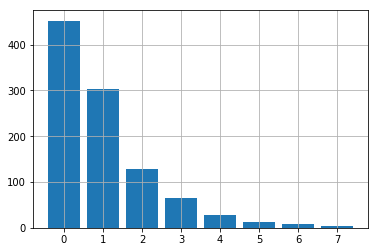

In [105]:
import numpy as np
plt.bar(x = np.array(list(d.items()))[:, 0],
        height = np.array(list(d.items()))[:, 1])
plt.grid()

### Grid

In [153]:
from mesa.space import MultiGrid, SingleGrid

In [187]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1
    """"""        
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center = False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
    """"""
class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        """create grid"""
        self.grid = MultiGrid(width, height, True)
        """"""
        self.schedule = RandomActivation(self)
        self.n_steps = 0
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            """assign agent into a cell"""
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            """"""
    def step(self):
        self.schedule.step()
        self.n_steps += 1

In [195]:
model = MoneyModel(50, 10, 10)

In [196]:
# Since some agents share a cell, there has to be some empty cells
import itertools
grids = list(itertools.product(range(10), range(10)))
empty_cells = []
for grid in grids:
    if model.grid.is_cell_empty(grid):
        empty_cells.append(grid)
print(empty_cells)
len(empty_cells)

[(0, 1), (0, 2), (0, 4), (0, 6), (0, 8), (1, 1), (1, 4), (1, 5), (1, 7), (1, 8), (2, 0), (2, 1), (2, 2), (2, 5), (2, 7), (2, 8), (2, 9), (3, 1), (3, 2), (3, 6), (3, 7), (3, 8), (4, 0), (4, 1), (4, 3), (4, 4), (4, 5), (4, 6), (4, 8), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 9), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (7, 0), (7, 1), (7, 2), (7, 4), (8, 0), (8, 1), (8, 2), (8, 3), (8, 4), (8, 5), (8, 6), (8, 8), (8, 9), (9, 0), (9, 2), (9, 3), (9, 6), (9, 9)]


60

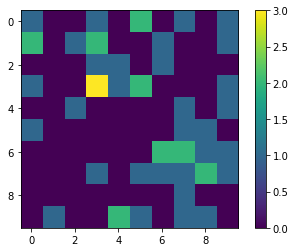

In [197]:
# check the initial state
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    content, x, y = cell
    agent_counts[x][y] = len(content)
plt.imshow(agent_counts)
plt.colorbar()
# in cell (3,3) 3 agents are together

In [204]:
# 3 agents!
model.grid.grid[3][3]

{<__main__.MoneyAgent at 0x1b4042a56a0>,
 <__main__.MoneyAgent at 0x1b407f5a898>}

### track each step by visualization

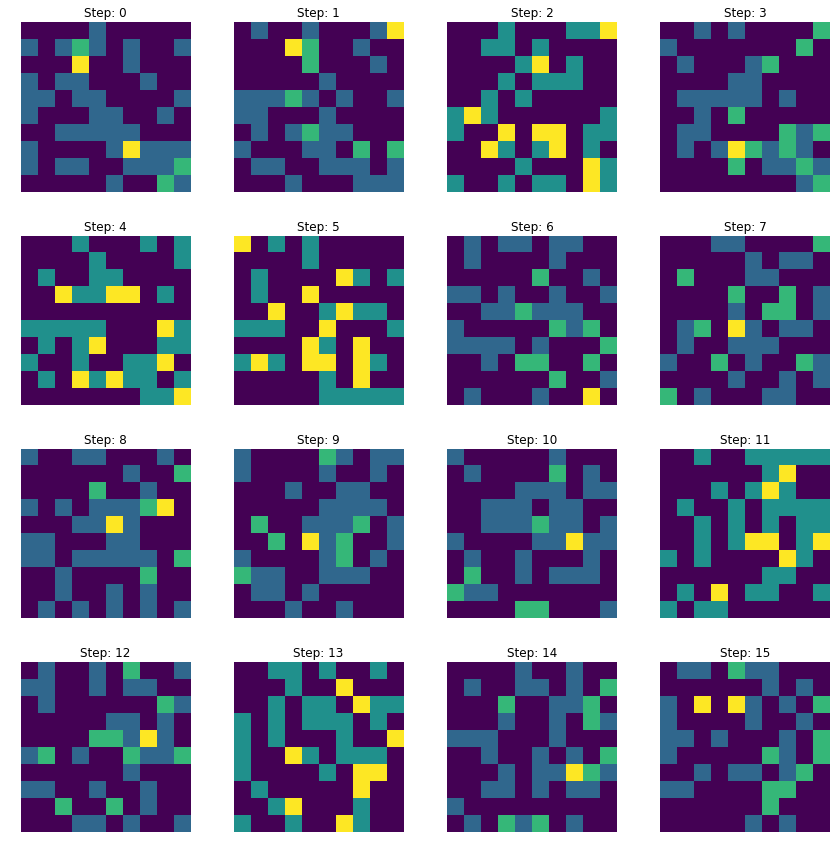

In [205]:
model = MoneyModel(50, 10, 10)
ncol = 4
nrow = 4
plt.figure(figsize=(3*ncol,3*nrow))

for i in range(ncol*nrow):
    plt.subplot(nrow,ncol,i+1, )
    agent_counts = np.zeros((model.grid.width, model.grid.height))
    for cell in model.grid.coord_iter():
        content, x, y = cell
        agent_counts[x][y] = len(content)
    plt.imshow(agent_counts)
    plt.title("Step: %s"%model.n_steps)
    plt.axis("off")
    model.step()
plt.tight_layout()

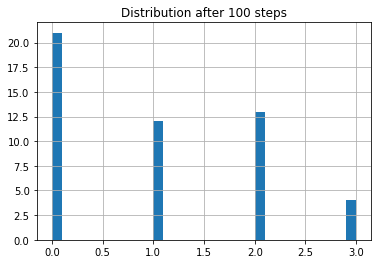

In [208]:
import matplotlib.pyplot as plt
%matplotlib inline
agent_wealths = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealths, bins = 30)
plt.title("Distribution after 100 steps")
plt.grid()
# and the inequality still increases over time

### Gini Index

In [225]:
model = MoneyModel(10, 5, 5)
agent_wealths = [a.wealth for a in model.schedule.agents]

x = sorted(agent_wealths)
N = model.num_agents
print(x)
print(N)
for i,xi in enumerate(x):
    print("xi:", xi)
    print("N-i:", N-i)
print([xi * (N-i) for i,xi in enumerate(x)])
print(sum([xi * (N-i) for i,xi in enumerate(x)]))
print("sum(x)*N:", sum(x)*N)
B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
print("B:", B)
print("1/N:",1/N)
print("2*B:",2*B)
print("Gini Index:", 1+(1/N)-2*B)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
10
xi: 1
N-i: 10
xi: 1
N-i: 9
xi: 1
N-i: 8
xi: 1
N-i: 7
xi: 1
N-i: 6
xi: 1
N-i: 5
xi: 1
N-i: 4
xi: 1
N-i: 3
xi: 1
N-i: 2
xi: 1
N-i: 1
[10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
55
sum(x)*N: 100
B: 0.55
1/N: 0.1
2*B: 1.1
Gini Index: 0.0


In [226]:
for i in range(20):
    model.step()
agent_wealths = [a.wealth for a in model.schedule.agents]

x = sorted(agent_wealths)
N = model.num_agents
print(x)
print(N)
for i,xi in enumerate(x):
    print("xi:", xi)
    print("N-i:", N-i)
print([xi * (N-i) for i,xi in enumerate(x)])
print(sum([xi * (N-i) for i,xi in enumerate(x)]))
print("sum(x)*N:", sum(x)*N)
B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
print("B:", B)
print("1/N:",1/N)
print("2*B:",2*B)
print("Gini Index:", 1+(1/N)-2*B)

[0, 0, 0, 0, 1, 1, 1, 2, 2, 3]
10
xi: 0
N-i: 10
xi: 0
N-i: 9
xi: 0
N-i: 8
xi: 0
N-i: 7
xi: 1
N-i: 6
xi: 1
N-i: 5
xi: 1
N-i: 4
xi: 2
N-i: 3
xi: 2
N-i: 2
xi: 3
N-i: 1
[0, 0, 0, 0, 6, 5, 4, 6, 4, 3]
28
sum(x)*N: 100
B: 0.28
1/N: 0.1
2*B: 0.56
Gini Index: 0.54


In [227]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [228]:
compute_gini(model)

0.54

### How to automatically store data for each run? (step)

In [206]:
from mesa.datacollection import DataCollector

In [253]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1   
    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore = True,
            include_center = False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    
    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)
            
class MoneyModel(Model):
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.n_steps = 0
        
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
        """"""
        self.datacollector = DataCollector(
            model_reporters = {"Gini": compute_gini}, # function to call
            agent_reporters = {"Wealth": "wealth"}) # agent's attribute
        """"""
    def step(self):
        """"""
        self.datacollector.collect(self)
        """"""
        self.schedule.step()
        self.n_steps += 1

In [321]:
model = MoneyModel(50, 10, 10)
print(compute_gini(model))
for i in range(1001):
    model.step()
print(compute_gini(model))

0.0
0.6528


[Text(0,0,''), Text(0,0,'0.5'), Text(0,0,'1.0')]

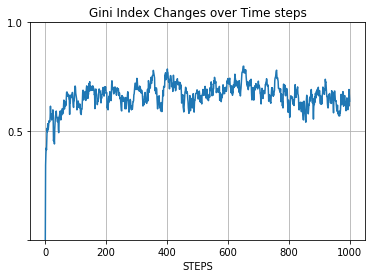

In [322]:
gini = model.datacollector.get_model_vars_dataframe()
fig, ax = plt.subplots()
gini.plot(ax=ax, grid = True, legend = False)
# ax.autoscale(tight = True)

ax.set_xlabel("STEPS")
ax.set_title("Gini Index Changes over Time steps")
ax.set_ylim(0,1)
ax.set_yticks([0.0,0.5,1.0])
ax.set_yticklabels(["","0.5","1.0"])

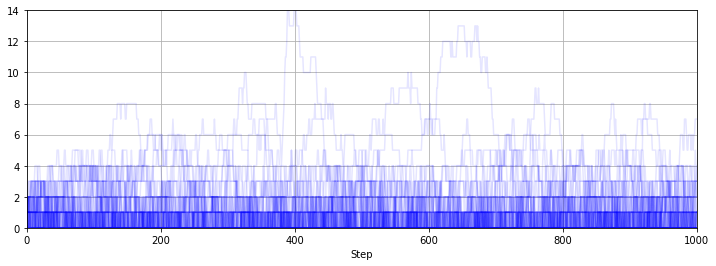

In [326]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
fig, ax = plt.subplots(figsize = (12,4))
agent_wealth.unstack().plot(ax=ax, color = "blue", alpha = 0.1, legend=False)
ax.autoscale(tight = True)
ax.grid()

In [435]:
d = agent_wealth.unstack().loc[400].values
d.sort()
d = d/d.sum()

In [472]:
import math
quantile = 0.10
i = int(math.floor(len(d)*(1-quantile)))
print(i, 1-d.cumsum()[i-1])

45 0.56


Text(0.5,1,'Population and Wealth Distribution\n"Top 10.0% of Rich People possess 56.0% of Total Wealth"')

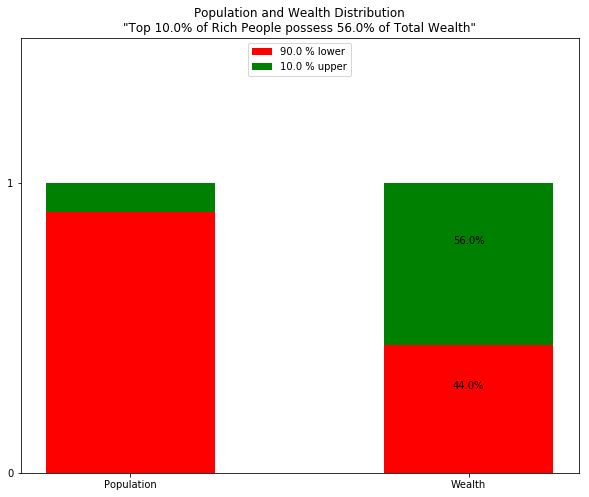

In [542]:
import math
quantile = 0.1
i = int(math.floor(len(d)*(1-quantile)))

width = 0.5

plt.figure(figsize = (10,8))

plt.bar(x = 1, height = 1-quantile, width = width, color = "red",
        label = "%s %% lower"%((1-quantile)*100))
plt.bar(x = 1, height = quantile, bottom = 1-quantile, width = width, color = "green",
        label = "%s %% upper"%((quantile)*100))

plt.bar(x = 2, height = d.cumsum()[i-1], width = width, color = "red")
plt.text(x = 2, y = 0.3, s = "%s%%"%np.round((d.cumsum()[i-1])*100, 2), verticalalignment='center', horizontalalignment='center')

plt.bar(x = 2, height = 1-d.cumsum()[i-1], bottom = d.cumsum()[i-1], width = width, color = "green")
plt.text(x = 2, y = 0.8, s = "%s%%"%np.round((1-d.cumsum()[i-1])*100, 2), verticalalignment='center', horizontalalignment='center')


plt.ylim(0,1.5)
plt.yticks([0,1])
plt.xticks([1,2], ("Population", "Wealth"))
plt.legend(loc = 9)
plt.title('Population and Wealth Distribution\n"Top {pop}% of Rich People possess {wealth}% of Total Wealth"'.format(pop=(quantile)*100, wealth=np.round((1-d.cumsum()[i-1])*100, 2)))